In [1]:
import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import kneighbors_graph,BallTree
from hmmlearn import hmm
# from pymc import MCMC,flib,Model,MAP
# from ripser import Rips,ripser,plot_dgms
# from persim import PersImage
# import scipy.io as sio
# import kmapper as km
# from kmapper import jupyter
from mpl_toolkits.mplot3d import Axes3D
from cell_class import single_cell,fluor_single_cell
import contour_class
import utility_tools
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
from scipy.signal import medfilt,wiener
from traj_class import single_cell_traj,fluor_single_cell_traj
# import bnpy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from itertools import product
from sklearn.cluster import DBSCAN,KMeans,MeanShift
from sklearn.metrics import silhouette_score,davies_bouldin_score
import glob
from pykalman import KalmanFilter
from neupy import algorithms, utils
from scipy.spatial import Voronoi, voronoi_plot_2d
from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import soft_dtw,dtw,dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw,cdist_soft_dtw_normalized
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter,euclidean_barycenter
from sklearn.manifold import MDS,TSNE,SpectralEmbedding
from scipy import signal,stats
from statsmodels.tsa.ar_model import AR
from numpy import linalg
from scipy.interpolate import CubicSpline,interp1d
from reactive_traj_classify import find_reaction_start_end,ar1_tipping_time,cross_corr_delay,find_intermediate_part
from sklearn.utils import shuffle
from reaction_coordinates import FindPath
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
from sklearn.neighbors import KernelDensity

C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\

In [2]:
#main_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/result_without_bgcorr/'
main_path='single_cell_traj/'

sct_path=main_path+'1ng_traj/'
#sct_list=sorted(listdir(sct_path))
sct_list=sorted(glob.glob(sct_path+'*long_traj'))
result_path=main_path+'rc_result/'

with open (main_path+'morph_pc_scaler','rb') as fp:
    morph_pc_scaler=pickle.load(fp,encoding='iso-8859-1')

with open (main_path+'vim_pc_scaler','rb') as fp:
    vim_pc_scaler=pickle.load(fp,encoding='iso-8859-1')
    
with open (main_path+'label_spread_4d','rb') as fp:
    ls=pickle.load(fp,encoding='iso-8859-1')


extend_path=np.load(main_path+'rc_result/extend_path.npy')
path=np.load(main_path+'rc_result/path.npy')
path_dsdt=np.load(main_path+'rc_result/dSdt.npy')

extend_path0=np.load(main_path+'rc_result/extend_path0.npy')
extend_path1=np.load(main_path+'rc_result/extend_path1.npy')
path0=np.load(main_path+'rc_result/path0.npy')
path1=np.load(main_path+'rc_result/path1.npy')
iU0=np.load(main_path+'rc_result/iU0.npy')
iU1=np.load(main_path+'rc_result/iU1.npy')
  
t_start=0
t_end=937
nrc=24
extend_range=3
branch_start=3
branch_end=27
print(len(path),len(extend_path),len(path_dsdt))

24 30 30


C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator NearestNeighbors from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LabelSpreading from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
all_traj=[]
all_t=[]
all_traj_state=[]
all_reaction_traj_fd=[]
all_reaction_traj=[]
all_reaction_t=[]
all_reaction_state=[]
cut_reaction_traj=[]
reactive_inds=[]
non_reactive_inds=[]
traj_ind=0

for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp,encoding='iso-8859-1')
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
            mask=sct.traj_vimentin_feature_values[0]!=0


            traj_t=sct.traj_seri[mask][:,0]
#             morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
#             vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            morph_traj=(sct.traj_scale_cord[mask]-morph_pc_scaler.mean_)/np.sqrt(morph_pc_scaler.var_)
            vim_traj=(sct.traj_vimentin_scale_haralick_pca_cord[mask]-vim_pc_scaler.mean_)/np.sqrt(vim_pc_scaler.var_)

            X0=np.column_stack((morph_traj,vim_traj))
            X=np.column_stack((morph_traj[:,0],vim_traj[:,[0,2,3]]))
            X[:,2]=-X[:,2]

            

            traj_state=ls.predict(X)
            traj_proba=ls.predict_proba(X)
            
            all_traj.append(X[np.where(traj_t<t_end)])
            all_t.append(traj_t[np.where(traj_t<t_end)])
            all_traj_state.append(traj_state[np.where(traj_t<t_end)])


            reaction_start,reaction_end,enter_M=find_reaction_start_end(traj_state,dwell_thres=3)
#             reaction_start,reaction_end,leave_E,enter_M=find_reaction_start_end(traj_state,dwell_thres=3)
            if reaction_end>reaction_start:
                reaction_start_t=traj_t[reaction_start]
                reaction_end_t=traj_t[reaction_end]
                print('t',reaction_start_t,reaction_end_t)
            

                if reaction_start_t<=216 and reaction_end_t>216:

                    print(reaction_start,reaction_end)

                    reaction_traj=X[reaction_start:reaction_end+1,:]
                    reaction_state=traj_state[reaction_start:reaction_end+1]
                    all_reaction_traj.append(reaction_traj)
                    all_reaction_state.append(reaction_state)
                    cut_reaction_traj.append(X[reaction_start:enter_M+1,:])
                    all_reaction_t.append(traj_t[reaction_start:reaction_end+1])
                    reactive_inds.append(traj_ind)
                    all_reaction_traj_fd.append(X0[reaction_start:reaction_end+1,:])
                else:
                    non_reactive_inds.append(traj_ind)
                    




            else:
                non_reactive_inds.append(traj_ind)
                
            traj_ind+=1


t 1.0 589.0
0 195
t 100.0 598.0
0 160
t 1.0 778.0
0 257
t 1.0 622.0
0 206
t 109.0 601.0
0 159
t 28.0 622.0
9 204
t 1.0 607.0
0 201
t 4.0 406.0
1 128
t 118.0 925.0
0 254
t 4.0 193.0
t 4.0 475.0
1 156
t 1.0 460.0
0 152
t 79.0 313.0
0 78
t 124.0 385.0
0 79
t 1.0 331.0
0 109
t 109.0 583.0
11 163
t 37.0 811.0
4 260
t 1.0 190.0
t 22.0 325.0
7 107
t 34.0 760.0
0 239
t 88.0 586.0
0 162
t 4.0 574.0
1 189
t 7.0 364.0
0 116
t 1.0 631.0
0 205
t 1.0 898.0
0 292
t 1.0 322.0
0 106
t 1.0 748.0
0 247
t 10.0 394.0
3 131
t 1.0 307.0
0 102
t 1.0 325.0
0 107
t 4.0 328.0
1 109
t 1.0 367.0
0 117
t 1.0 307.0
0 101
t 4.0 247.0
1 82
t 1.0 322.0
0 107
t 103.0 580.0
0 150
t 34.0 553.0
11 184
t 4.0 457.0
1 150
t 103.0 466.0
0 118
t 31.0 421.0
4 132
t 13.0 514.0
0 164
t 31.0 535.0
0 163
t 136.0 463.0
3 112
t 139.0 766.0
0 204
t 13.0 454.0
4 151
t 73.0 421.0
0 115
t 1.0 298.0
0 98
t 1.0 238.0
0 79
t 100.0 625.0
0 175
t 1.0 358.0
0 119
t 4.0 421.0
1 138
t 1.0 526.0
0 169
t 85.0 574.0
0 163
t 22.0 418.0
7 138
t 106.0 

[0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1] 21


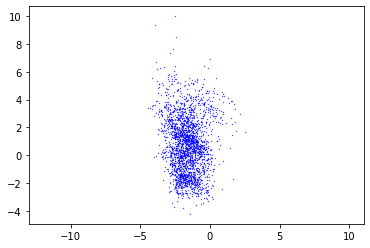

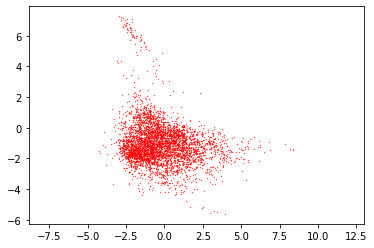

In [4]:
X=to_time_series_dataset(cut_reaction_traj)
km_dba = TimeSeriesKMeans(n_clusters=2, metric="dtw",max_iter=20,max_iter_barycenter=10,random_state=0).fit(X)#metric_params={"gamma": 20}, 
Y=km_dba.labels_


print(Y,len(Y[Y==0]))
# dot_color=np.arange(km_dba.cluster_centers_.shape[1])
# cm=plt.get_cmap('jet')
for i in range(len(X)):
    if Y[i]==0:
        plt.scatter(X[i][:,0],X[i][:,1],s=0.1,color='blue')
# print(km_dba.cluster_centers_.shape)
# plt.scatter(km_dba.cluster_centers_[0,:,0],km_dba.cluster_centers_[0,:,1],s=15,c=dot_color,cmap=cm)
plt.axis('equal')

plt.show()

for i in range(len(X)):
    if Y[i]==1:
        plt.scatter(X[i][:,0],X[i][:,1],s=0.1,color='red')
#plt.scatter(km_dba.cluster_centers_[1,:,0],km_dba.cluster_centers_[1,:,1],s=15,c=dot_color,cmap=cm)
plt.axis('equal')
plt.show()

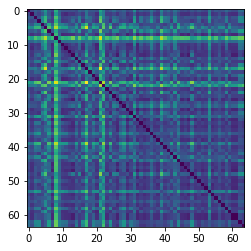

In [5]:
sct_cdist=cdist_dtw(X)
# sct_cdist=cdist_soft_dtw_normalized(X,gamma=10)
# np.save(result_path+'sct_soft_cdist.npy',sct_cdist)

plt.imshow(sct_cdist)
plt.show()

C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


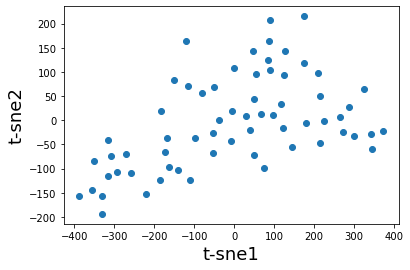

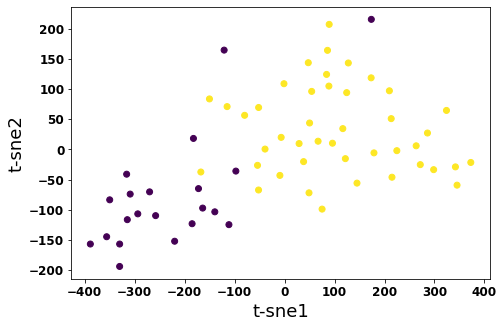

In [6]:
tsne = TSNE(n_components=2, perplexity=6.0,early_exaggeration=30.0,  metric='precomputed')
Y1 = tsne.fit_transform(sct_cdist)
# Y1=np.load(result_path+'sct_dist_tsne.npy')
plt.scatter(Y1[:,0],Y1[:,1])
plt.xlabel('t-sne1',fontsize=18)
plt.ylabel('t-sne2',fontsize=18)
plt.show()
plt.figure(figsize=(7.5,5))
plt.scatter(Y1[:,0],Y1[:,1],c=Y)
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.xlabel('t-sne1',fontsize=18)
plt.ylabel('t-sne2',fontsize=18)
# plt.savefig(result_path+'1ng_traj_sct_tsne.tif',dpi=300)

plt.show()

In [7]:
# np.save(result_path+'sct_dist_tsne.npy',Y1)

In [8]:
data_rc=[]
for ind in range(len(all_traj)):
    traj_t_span=all_traj[ind].shape[0]
    traj_rc=np.zeros((all_traj[ind].shape[0],))
    for i in range(traj_t_span):
        p = all_traj[ind][i,:]
        dist = linalg.norm(extend_path - p[None,:], axis = 1)
        traj_rc[i]=np.argmin(dist)
#     plt.scatter(np.arange(traj_rc.shape[0]-1),np.diff(traj_rc)/2.0)
#     plt.show()
    data_rc.append(traj_rc)
print(len(data_rc))

138


In [9]:
rc_grad=[[] for i in range(len(extend_path))]
rc_grad_sign=[[] for i in range(len(extend_path))]
rc_pts=[[] for i in range(len(extend_path))]


rc_real_grad=[[] for i in range(len(extend_path))]

for i in range(len(all_traj)):
    rc_traj=data_rc[i]
#     print(rc_traj)
    traj_len=rc_traj.shape[0]-1
    traj_t=all_t[i]
    rc_traj_grad=np.diff(rc_traj,axis=0)
    traj_grad=np.diff(all_traj[i],axis=0)

    for t_ind in np.where((traj_t>=t_start)&(traj_t<t_end))[0][:-1]:
        rc_grad[int(rc_traj[t_ind])].append((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind]))
        rc_grad_sign[int(rc_traj[t_ind])].append(np.sign((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind])))
        rc_pts[int(rc_traj[t_ind])].append(all_traj[i][t_ind,:])
        rc_real_grad[int(rc_traj[t_ind])].append(traj_grad[t_ind,:])

In [10]:
rc_flux_v=np.zeros((len(extend_path),))
rc_flux_D=np.zeros((len(extend_path),))
for j in range(len(extend_path0)):
#     plt.hist(np.array(rc_grad[j]))
#     plt.show()
    rc_flux_v[j]=np.mean(np.array(rc_grad[j]))
    rc_flux_D[j]=np.var(np.array(rc_grad[j]))

In [11]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)

rc0 [42 43 44 45]
[ 8. 10.  9.  8.]
rc0 [60 61 62 63 64 65 66 67 68 69 70 71 72 73]
[ 9. 10.  9. 10.  9. 11. 10. 11. 13. 12. 12. 11. 10. 11.]
rc1 [ 4  5  6  7  8  9 10 11 12 13]
[0. 4. 2. 3. 3. 3. 5. 4. 5. 3.]
rc1 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[1. 0. 3. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rc1 [36 37 38 39 40 41]
[0. 0. 0. 0. 0. 0.]
rc1 [48 49 50 51 52 53]
[0. 0. 0. 0. 0. 0.]
rc1 [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102]
[12. 13. 13. 12. 13. 12. 11. 12. 12. 13. 14. 12. 13. 12. 16. 13. 14. 13.
 14. 14. 12. 12. 12. 11. 12. 11. 14. 12. 11.]
rc1 [104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125]
[11. 13. 13. 11. 14. 15. 14. 13. 14. 14. 14. 15. 15. 15. 13. 15. 15. 15.
 16. 15. 14. 11.]
rc1 [127 128 129 130 131 132 133 134]
[12. 12. 11. 11. 11. 12. 14. 10.]
rc1 [137 138 139 140 141 142]
[12. 11. 13. 14. 11. 15.]
rc1 [144 145 146 147 148 149]
[14. 1

rc1 [42 43 44 45 46 47 48 49 50 51 52 53 54]
[ 7.  8.  6.  8.  9.  7.  8.  9.  9. 10. 10.  8.  8.]
rc1 [57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
[ 8.  9.  6.  8.  7.  9. 10. 10. 10. 10.  8.  9.  8. 10.  9. 11.  8. 10.
  9.]
rc1 [77 78 79 80]
[11. 11. 10.  7.]
rc1 [83 84 85 86 87 88]
[10. 10.  9. 11.  9. 11.]
rc1 [93 94 95 96 97 98]
[11. 11. 11.  9. 11. 11.]
rc1 [136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172]
[11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 10. 11. 11. 11. 11. 11. 11. 11.
 11.]
rc0 [30 31 32 33 34 35 36 37]
[12. 14. 12. 14. 14. 13. 11. 11.]
rc0 [48 49 50 51 52 53 54 55 56 57 58]
[10. 12. 10. 13. 11. 12. 13. 12. 12. 12. 11.]
rc0 [61 62 63 64 65]
[9. 9. 9. 9. 9.]
rc0 [69 70 71]
[13. 12. 11.]
rc0 [ 73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  

rc0 [28 29 30 31]
[1. 3. 1. 5.]
rc0 [34 35 36 37 38]
[5. 6. 5. 1. 4.]
rc0 [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111]
[ 4.  7.  1.  5.  5.  5.  6.  6.  4.  1.  6.  6.  8. 13.  9. 10. 11.  9.
 15. 11. 11. 10.  7.  8.  9. 10. 11. 11. 11. 11. 12. 13. 16. 14. 11. 14.
 12. 12. 12. 11. 13. 13. 13. 14. 13. 13. 12. 13. 11. 10. 12.  9. 10. 12.
 11. 14. 13. 14. 14. 14. 14. 16.]
rc0 [116 117 118 119 120 121 122 123]
[15. 19. 17. 18. 17. 17. 14. 15.]
rc1 [0 1 2]
[5. 4. 5.]
rc1 [39 40 41 42]
[5. 5. 4. 3.]
rc1 [44 45 46]
[7. 7. 8.]
rc1 [124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
[15. 14. 14. 14. 14. 14. 14. 14. 17. 17. 17. 15. 16. 14. 14. 15. 14. 14.
 15. 15. 15. 15. 15. 16. 16. 16. 1

rc0 [16 17 18]
[6. 6. 7.]
rc0 [24 25 26 27 28]
[10.  9.  9.  9.  7.]
rc0 [30 31 32]
[10. 11. 11.]
rc0 [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]
[10. 12. 11. 12. 11. 10. 12. 12. 11. 13. 11. 11. 11. 19. 13. 12. 10. 12.]
rc0 [56 57 58 59 60 61 62]
[13. 12. 12. 14. 14. 10. 13.]
rc0 [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152]
[14. 12. 13. 13. 14. 16. 13. 11. 14. 14. 15. 15. 13. 12. 13. 14. 12. 14.
 14. 13. 12. 15. 15. 16. 14. 15. 15. 15. 15. 16. 15. 18. 17. 17. 17. 17.
 17. 16. 14. 15. 16. 14. 15. 18. 15. 15. 14. 14. 14. 16. 15. 15. 16. 17.
 17. 17. 16. 18. 18. 17. 18. 17. 17. 17. 17. 21. 19. 19. 18. 18. 18. 20.
 21. 19. 19. 18. 18. 17. 15. 16. 17. 17. 21. 19. 19. 18. 

rc0 [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153]
[21. 22. 19. 18. 21. 20. 21. 19. 18. 18. 18. 15. 16. 15. 16. 18. 16. 20.
 14. 15. 18. 17. 19. 19. 18. 19. 18.]
rc0 [169 170 171 172 173 174 175 176 177 178 179 180]
[20. 21. 11. 14.  9. 20. 20. 16. 13. 13. 20. 22.]
rc1 [0 1 2 3 4 5]
[6. 5. 6. 5. 5. 5.]
rc1 [20 21 22]
[4. 3. 4.]
rc1 [ 28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109]
[ 7.  8.  8.  7.  9.  7.  8.  8.  8.  8.  9. 10.  9.  9. 10.  8.  9. 10.
  8.  9. 10. 11. 11. 12. 14. 11. 11. 10. 10. 10. 10. 11. 11. 12. 11. 11.
 12. 11. 12. 13. 12. 13. 12. 12. 12. 12. 12. 11. 11. 12. 12. 12. 12. 13.
 12. 12. 12. 12. 11. 10. 12. 13. 13. 15. 15. 12. 

rc0 [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
[10.  8.  7.  9.  8.  8.  8.  7.  9. 11.  9. 10. 11.  9.  8.  8.  8.  4.
  7.  8.]
rc0 [33 34 35]
[8. 8. 9.]
rc0 [48 49 50 51 52 53]
[12. 12.  9. 10. 11. 13.]
rc1 [36 37 38 39]
[11. 10.  9. 11.]
rc1 [44 45 46 47]
[ 7.  9.  8. 10.]
rc1 [54 55 56 57]
[11. 12. 12. 12.]
rc1 [63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]
[12. 12. 11. 12. 12. 12. 13. 12. 12. 12. 12. 11. 12. 11. 12. 13. 15. 15.
 15.]
rc0 [0 1 2 3 4]
[11. 15. 15. 13. 12.]
rc0 [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
[11. 12. 11. 13. 13. 12. 13. 11. 15. 15. 15. 14. 12. 13. 11.]
rc0 [31 32 33 34 35 36 37]
[11. 11. 11. 12. 11. 11. 11.]
rc0 [39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86
 87 88 89]
[11. 13. 13. 13. 13. 11. 11. 15. 13. 14. 12. 14. 12. 14. 14. 14. 14. 13.
 15. 14. 12. 11. 14. 14. 16. 12. 16. 16. 16. 16. 12. 13. 16. 13. 16. 16.
 16. 16. 1

rc0 [74 75 76 77 78 79 80 81 82]
[12. 11. 10.  9. 11. 10. 10. 11. 11.]
rc0 [ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112]
[14. 15. 15. 15. 14. 15. 15. 15. 15. 15. 15. 15. 15. 14. 15. 15. 15. 15.
 15. 15. 15. 15. 14. 12. 15. 13. 14.]
rc0 [114 115 116]
[15. 15.  9.]
rc1 [7 8 9]
[0. 0. 0.]
rc1 [12 13 14]
[0. 0. 0.]
rc0 [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 4.  2.  2.  2.  2.  2.  2.  2.  2. 12.  2.  8.  2.  7.  7.  5.  8.  8.]
rc0 [80 81 82 83]
[29. 29. 29. 29.]
rc1 [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
[14. 11. 13. 11.  9.  9.  9.  9.  9. 10. 11. 13. 12. 15. 14. 18. 16. 17.
 16. 16. 18. 16. 16. 18. 16. 16. 17. 20. 22. 23. 19. 18. 21. 22. 20. 20.
 21. 21. 20. 21. 20. 21. 20. 22. 22. 24.]
rc1 [94 95 96]
[23. 24. 24.]
rc1 [ 98  99 100 101 102 103 104]
[21. 20. 21. 24. 24. 24. 20.]
rc1 [107 108 109]
[22.  6.

rc0 [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 4.  4.  5.  5. 11. 10. 18. 16. 16. 16. 19. 20. 21. 20. 21. 18. 20. 21.
 20. 19. 15. 21. 19. 19. 16. 19. 19. 20. 20. 17. 21. 22. 23. 22. 21. 23.
 22. 19. 19.]
rc0 [47 48 49 50 51 52]
[23. 23. 23. 21. 22. 23.]
rc0 [65 66 67 68]
[23. 22. 21. 22.]
rc0 [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
[19. 23. 18. 19. 22. 18. 23. 23. 21. 20. 19. 22. 18.  9. 19. 19. 18. 17.
 17. 17. 17. 17. 20. 18. 18. 18. 19. 20. 15. 22. 22. 23. 22. 17. 19.]
rc0 [109 110 111 112]
[19. 21. 20. 20.]
rc0 [127 128 129 130 131 132 133 134 135 136 137]
[19. 18. 15. 15. 17. 18. 13. 16. 13. 16. 18.]
rc1 [2 3 4 5 6]
[3. 4. 2. 2. 2.]
rc1 [56 57 58 59 60 61 62]
[18. 15. 13. 21. 15. 17. 17.]
rc1 [116 117 118]
[14. 18. 11.]
rc1 [146 147 148 149]
[19. 22. 14. 20.]
rc0 [ 4  5  6  7  8  9 10]
[19. 16. 17. 18

[29. 29. 29. 29. 29.]
rc1 [161 162 163]
[29. 29. 29.]
rc0 [33 34 35]
[10.  8.  5.]
rc0 [42 43 44 45 46 47 48 49 50 51]
[ 9. 11. 10. 11.  9.  8.  9.  6.  4.  3.]
rc0 [ 67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110]
[ 8.  9. 11. 12. 10.  9.  9.  9.  9.  9. 10.  9.  8. 10. 11.  9.  9. 10.
  9. 10. 10.  9.  8. 10. 10. 11.  9. 10. 11. 10. 13. 11. 15. 12. 12. 10.
 11. 11. 10. 10. 11. 12. 13. 12.]
rc0 [112 113 114 115 116 117]
[12. 13. 12. 13. 13. 14.]
rc1 [3 4 5 6 7 8 9]
[5. 5. 6. 4. 5. 5. 7.]
rc1 [12 13 14 15]
[5. 1. 1. 1.]
rc1 [17 18 19 20 21 22 23]
[3. 1. 3. 1. 3. 7. 5.]
rc1 [25 26 27 28]
[1. 1. 1. 1.]
rc1 [36 37 38 39 40 41]
[4. 6. 1. 1. 1. 1.]
rc1 [61 62 63 64 65 66]
[1. 1. 1. 1. 2. 4.]
rc0 [39 40 41]
[1. 0. 2.]
rc0 [ 55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  9

rc1 [46 47 48]
[10. 13. 12.]
rc1 [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
[13. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 13. 15. 15. 15. 15. 15.
 15.]
rc1 [70 71 72 73 74 75 76]
[15. 15. 14. 15. 15. 14. 15.]
rc1 [ 98  99 100 101 102 103 104 105 106 107 108 109 110 111]
[10.  9. 11. 12. 11. 11.  8. 10. 11. 11. 11. 10. 12. 14.]
rc0 [16 17 18]
[ 8.  8. 10.]
rc0 [55 56 57 58]
[20. 20. 20. 21.]
rc0 [133 134 135 136]
[29. 29. 29. 29.]
rc0 [155 156 157]
[29. 29. 29.]
rc0 [161 162 163 164 165 166]
[29. 29. 29. 29. 29. 29.]
rc0 [170 171 172 173 174 175]
[29. 29. 29. 29. 29. 29.]
rc1 [ 6  7  8  9 10 11]
[2. 2. 2. 2. 3. 2.]
rc1 [19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51 52 53 54]
[ 6.  8. 10.  9. 12. 12. 10. 10. 10. 11. 11. 11.  9. 10. 10. 10.  9. 12.
 11. 12. 13. 13. 14. 16. 14. 13. 13. 14. 11. 13. 15. 17. 17. 16. 22. 21.]
rc1 [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87

rc0 [56 57 58 59 60]
[17. 18. 15. 13. 16.]
rc0 [125 126 127 128 129]
[22. 25. 26. 25. 25.]
rc0 [133 134 135 136 137 138 139 140 141 142 143 144 145 146 147]
[24. 27. 27. 27. 24. 25. 27. 27. 26. 27. 27. 25. 26. 27. 27.]
rc0 [154 155 156]
[27. 26. 27.]
rc1 [7 8 9]
[0. 1. 0.]
rc1 [19 20 21]
[5. 2. 4.]
rc1 [23 24 25 26 27 28 29]
[0. 6. 1. 4. 4. 5. 0.]
rc1 [61 62 63 64]
[13. 13. 11. 12.]
rc1 [67 68 69]
[13. 11. 13.]
rc1 [71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[14. 12. 13. 14. 13. 13. 13. 16. 14. 14. 15. 16. 15. 14. 14. 16. 14. 17.
 15. 16.]
rc1 [93 94 95 96]
[17. 17. 18. 16.]
rc1 [101 102 103 104 105 106 107 108 109 110]
[16. 16. 16. 17. 16. 17. 17. 19. 20. 17.]
rc1 [112 113 114 115 116 117 118 119 120 121 122 123 124]
[19. 23. 21. 16. 18. 20. 20. 20. 23. 21. 23. 23. 22.]
rc1 [150 151 152 153]
[23. 21. 23. 23.]
rc1 [163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180]
[22. 19. 20. 18. 19. 18. 17. 21. 21. 21. 20. 21. 19. 20. 21. 22. 19. 22.]
rc0 [ 8 

rc1 [50 51 52 53]
[13. 11. 10. 11.]
rc1 [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87]
[12. 12. 13. 13. 13. 13. 14. 13. 14. 14. 14. 13. 13. 12. 12. 10. 10.  9.
  9. 11. 11. 10. 10.  9. 10. 10.  8.  7.  8.  8.  7.  7.  6.]
rc1 [ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109]
[6. 6. 6. 7. 9. 8. 8. 9. 9. 8. 8. 7. 7. 6. 7. 8. 7. 5. 7.]
rc1 [115 116 117 118 119 120]
[3. 4. 4. 0. 0. 0.]
rc1 [131 132 133]
[1. 6. 6.]
rc1 [140 141 142 143 144 145 146]
[13. 12. 11. 12. 10. 14. 14.]
rc1 [148 149 150 151]
[14. 14. 13. 13.]
rc0 [15 16 17]
[0. 1. 0.]
rc0 [26 27 28 29]
[8. 4. 6. 9.]
rc0 [43 44 45 46]
[10. 10.  8.  7.]
rc0 [48 49 50 51 52]
[8. 8. 7. 7. 7.]
rc0 [57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76]
[10. 11. 11. 11. 12. 13. 12. 11. 12. 10.  9. 10. 10. 12. 10.  8. 10. 10.
 10. 11.]
rc0 [78 79 80 81 82]
[13. 11. 12. 13. 12.]
rc0 [ 98  99 100 101 102 103 104]
[17. 17. 16. 14. 15. 16. 14.]
rc0 [106 1

rc0 [ 8  9 10]
[3. 3. 5.]
rc0 [19 20 21 22 23 24 25]
[ 9.  8. 13. 11. 14. 14. 12.]
rc0 [31 32 33 34 35 36 37]
[12. 12. 13. 12. 14. 13. 16.]
rc0 [46 47 48 49]
[20. 20. 20. 20.]
rc0 [59 60 61]
[20. 20. 20.]
rc0 [71 72 73 74]
[20. 20. 20. 20.]
rc0 [79 80 81 82 83 84 85 86 87 88]
[17. 11. 11. 20. 12. 15. 12. 14. 20. 20.]
rc1 [0 1 2 3 4 5 6 7]
[3. 1. 3. 3. 3. 1. 1. 1.]
rc1 [13 14 15]
[4. 4. 4.]
rc1 [43 44 45]
[17. 15. 14.]
rc1 [64 65 66 67]
[23. 23. 19. 23.]
rc1 [75 76 77 78]
[23. 19. 23. 23.]
rc0 [ 8  9 10]
[3. 3. 5.]
rc0 [19 20 21 22 23 24 25]
[ 9.  8. 13. 11. 14. 14. 12.]
rc0 [31 32 33 34 35 36 37]
[12. 12. 13. 12. 14. 13. 16.]
rc0 [46 47 48 49]
[20. 20. 20. 20.]
rc0 [59 60 61]
[20. 20. 20.]
rc0 [71 72 73 74]
[20. 20. 20. 20.]
rc0 [79 80 81 82 83 84 85 86 87 88]
[17. 11. 11. 20. 12. 15. 12. 14. 20. 20.]
rc1 [0 1 2 3 4 5 6 7]
[3. 1. 3. 3. 3. 1. 1. 1.]
rc1 [13 14 15]
[4. 4. 4.]
rc1 [43 44 45]
[17. 15. 14.]
rc1 [64 65 66 67]
[23. 23. 19. 23.]
rc1 [75 76 77 78]
[23. 19. 23. 23.]
rc0 [4 5 6]


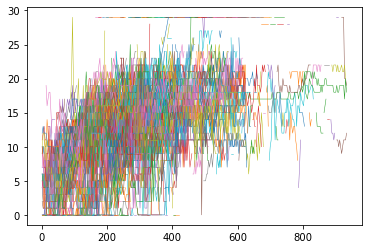

In [12]:
part_traj=[]
part_traj_rc=[]
part_traj_t=[]
part_traj_cl_label=[]
part_traj_state=[]
cl0_last_rc=[]
cl1_last_rc=[]
#------partial align to the paths
jump_out_thres=2
for ind in range(len(all_traj)):

    
    traj_rc=-1*np.ones((all_traj[ind].shape[0],2))
    part_inds=np.arange(all_traj[ind].shape[0])
    rc0_match_inds=np.unique(np.asarray(dtw_subsequence_path(all_traj[ind],extend_path0)[0])[:,1])
#     print(rc0_match_inds)
    
    rc1_match_inds=np.unique(np.asarray(dtw_subsequence_path(all_traj[ind],extend_path1)[0])[:,1])
#     print(rc1_match_inds)
    rc0_match=extend_path0[rc0_match_inds,:]
    rc1_match=extend_path1[rc1_match_inds,:]

    for i in range(len(all_traj[ind])):

        p = all_traj[ind][i,:]

        dist0 = linalg.norm(rc0_match- p[None,:], axis = 1)
        dist1 = linalg.norm(rc1_match- p[None,:], axis = 1)
        if np.amin(dist0)<np.amin(dist1):
            traj_rc[i,0]=rc0_match_inds[np.argmin(dist0)]
        else:
            traj_rc[i,1]=rc1_match_inds[np.argmin(dist1)]

    part_inds_rc0=part_inds[np.where(traj_rc[:,0]!=-1)]
    part_inds_rc1=part_inds[np.where(traj_rc[:,1]!=-1)]
#     print(traj_rc)
    
    for k in range(len(consecutive_arrs(part_inds_rc0))):
        if len(consecutive_arrs(part_inds_rc0)[k])>jump_out_thres:
            part_inds=consecutive_arrs(part_inds_rc0)[k]
            print('rc0',part_inds)
            print(traj_rc[:,0][part_inds])
            
            part_traj_t.append(all_t[ind][part_inds])
            part_traj_rc.append(traj_rc[:,0][part_inds])
            
            part_traj.append(all_traj[ind][part_inds])
            part_traj_state.append(all_traj_state[ind][part_inds])
            part_traj_cl_label.append(0)
            cl0_last_rc.extend(traj_rc[:,0][part_inds][np.where((all_t[ind][part_inds]>577)&(all_t[ind][part_inds]<937))].tolist())

            plt.plot(all_t[ind][part_inds],traj_rc[:,0][part_inds],linewidth=0.5)


    
    for k in range(len(consecutive_arrs(part_inds_rc1))):
        if len(consecutive_arrs(part_inds_rc1)[k])>jump_out_thres:
            part_inds=consecutive_arrs(part_inds_rc1)[k]
            print('rc1',part_inds)
            print(traj_rc[:,1][part_inds])
            
            part_traj_t.append(all_t[ind][part_inds])
            part_traj_rc.append(traj_rc[:,1][part_inds])
            part_traj.append(all_traj[ind][part_inds])
            part_traj_state.append(all_traj_state[ind][part_inds])
            part_traj_cl_label.append(1)
            cl1_last_rc.extend(traj_rc[:,1][part_inds][np.where((all_t[ind][part_inds]>577)&(all_t[ind][part_inds]<937))].tolist())

            plt.plot(all_t[ind][part_inds],traj_rc[:,1][part_inds],linewidth=0.5)
plt.show()

In [13]:
rc_grad0=[[] for i in range(len(extend_path0))]
rc_grad1=[[] for i in range(len(extend_path1))]
rc_grad_sign0=[[] for i in range(len(extend_path0))]
rc_grad_sign1=[[] for i in range(len(extend_path1))]
rc_pts0=[[] for i in range(len(extend_path0))]
rc_pts1=[[] for i in range(len(extend_path1))]

rc_real_grad0=[[] for i in range(len(extend_path0))]
rc_real_grad1=[[] for i in range(len(extend_path1))]

for i in range(len(part_traj_rc)):
    rc_traj=part_traj_rc[i]
#     print(rc_traj)
    traj_len=rc_traj.shape[0]-1
    traj_t=part_traj_t[i]
#     print(traj_t)
    rc_traj_grad=np.diff(rc_traj,axis=0)
    traj_grad=np.diff(part_traj[i],axis=0)
#     print(rc_traj.shape,traj_t.shape)
    if part_traj_cl_label[i]==0:
        for t_ind in np.where((traj_t>=t_start)&(traj_t<t_end))[0][:-1]:
    
            rc_grad0[int(rc_traj[t_ind])].append((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind]))
            rc_grad_sign0[int(rc_traj[t_ind])].append(np.sign((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind])))
            rc_pts0[int(rc_traj[t_ind])].append(part_traj[i][t_ind,:])
            rc_real_grad0[int(rc_traj[t_ind])].append(traj_grad[t_ind,:])


    else:
        for t_ind in np.where((traj_t>=t_start)&(traj_t<t_end))[0][:-1]:
            rc_grad1[int(rc_traj[t_ind])].append((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind]))
            rc_grad_sign1[int(rc_traj[t_ind])].append(np.sign((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind])))
            rc_pts1[int(rc_traj[t_ind])].append(part_traj[i][t_ind,:])
            rc_real_grad1[int(rc_traj[t_ind])].append(traj_grad[t_ind,:])

[ 0.40599769  0.39408794  0.24334772  0.31372549  0.36714976  0.35051546
  0.29320988  0.291939    0.12047441  0.13463463  0.05849359  0.06726457
  0.05102401  0.02042999 -0.07177517 -0.02230483 -0.07652934 -0.06736527
 -0.03462158 -0.03163842 -0.15333333 -0.15762274 -0.19573643 -0.2979798
 -0.33333333 -0.36363636 -0.7101227  -0.69248826 -0.64498645 -0.67258883]


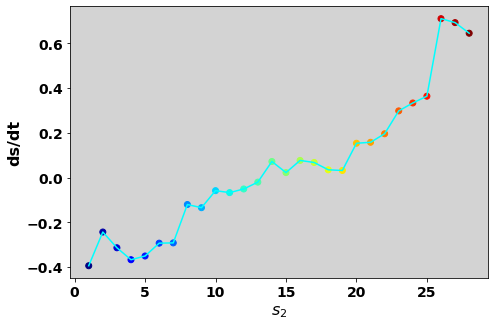

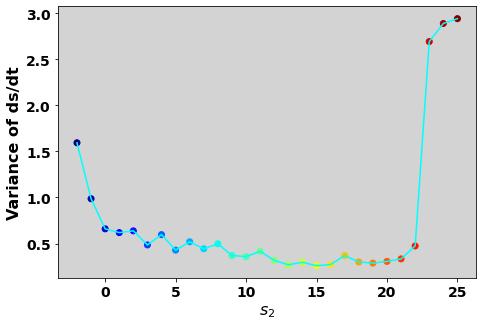

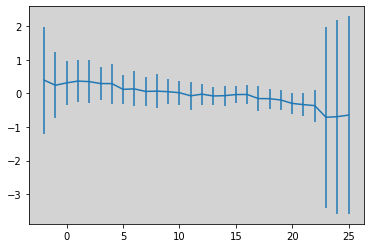

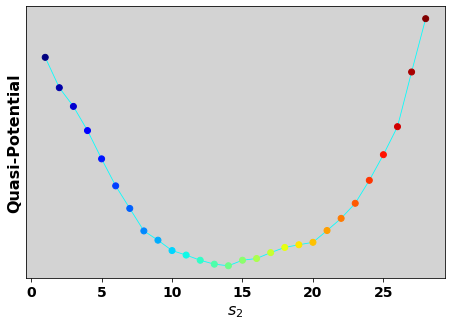

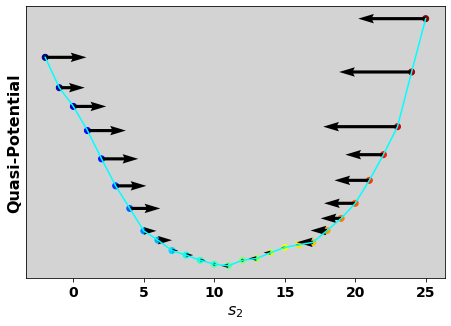

In [14]:
rc_flux_v0=np.zeros((len(extend_path0),))
rc_flux_D0=np.zeros((len(extend_path0),))
for j in range(len(extend_path0)):
#     plt.hist(np.array(rc_grad[j]))
#     plt.show()
    rc_flux_v0[j]=np.mean(np.array(rc_grad0[j]))
    rc_flux_D0[j]=np.var(np.array(rc_grad0[j]))
    
rc_flux_v0[:branch_start]=rc_flux_v[:branch_start]
rc_flux_v0[branch_end-1:]=rc_flux_v[branch_end-1:]

rc_flux_D0[:branch_start]=rc_flux_D[:branch_start]
rc_flux_D0[branch_end-1:]=rc_flux_D[branch_end-1:]

print(rc_flux_v0)
plt.figure(figsize=(7.5,5))
plt.rcParams['axes.facecolor'] = 'lightgray' 

dot_color=np.arange(extend_path0.shape[0]-2)
cm=plt.cm.get_cmap('jet')
plt.plot(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],color='cyan')

plt.scatter(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],c=dot_color,cmap=cm)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'1ng_rc0_dSdt.png',dpi=300)
plt.show()

plt.figure(figsize=(7.5,5))
plt.plot(np.arange(-extend_range+1,nrc+extend_range-1),rc_flux_D0[1:-1],color='cyan')

plt.scatter(np.arange(-extend_range+1,nrc+extend_range-1),rc_flux_D0[1:-1],c=dot_color,cmap=cm)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Variance of ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'1ng_rc0_dSdt_var.png',dpi=300)
plt.show()
plt.errorbar(np.arange(-extend_range+1,nrc+extend_range-1),rc_flux_v0[1:-1],yerr=rc_flux_D0[1:-1])
plt.show()

quasi_V0=np.zeros((rc_flux_v0.shape[0]-2,))
for k in range(len(extend_path0)-2):
    quasi_V0[k]=np.sum(-rc_flux_v0[1:k+1])
plt.figure(figsize=(7.5,5))

plt.plot(np.arange(1,quasi_V0.shape[0]+1),quasi_V0,linewidth=0.8,color='cyan',zorder=1)

plt.scatter(np.arange(1,quasi_V0.shape[0]+1),quasi_V0,c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.savefig(result_path+'1ng_rc0_potential.png',dpi=300)
plt.show()


plt.figure(figsize=(7.5,5))

plt.plot(np.arange(-extend_range+1,nrc+extend_range-1),quasi_V0,color='cyan')
plt.scatter(np.arange(-extend_range+1,nrc+extend_range-1),quasi_V0,c=dot_color,cmap=cm)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.quiver(np.arange(-extend_range+1,nrc+extend_range-1),quasi_V0,rc_flux_v0[1:-1],np.zeros_like(quasi_V0),scale=4)
plt.savefig(result_path+'rc0_potential_vf.png',dpi=300)

plt.show()

np.save(result_path+'1ng_rc0_var.npy',rc_flux_D0[1:-1])
np.save(result_path+'1ng_iU0.npy',quasi_V0)

0 594
1 147
2 102
3 158
4 234
5 204
6 230
7 256
8 266
9 304
10 365
11 518
12 534
13 513
14 592
15 575
16 486
17 536
18 396
19 373
20 227
21 178
22 119
23 50
24 20
25 9
26 3
27 0
28 0
29 435
[ 0.40599769  0.39408794  0.24334772  0.0907173   0.00356125  0.02777778
  0.05700483  0.11306424  0.09273183  0.10087719  0.08835616  0.06563707
  0.03662089  0.0455143   0.02640364 -0.00859903  0.01143118  0.01782753
 -0.07470539 -0.00670241 -0.08370044 -0.16104869 -0.40896359 -0.5
 -0.45       -0.92592593 -0.7101227  -0.69248826 -0.64498645 -0.67258883]


C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


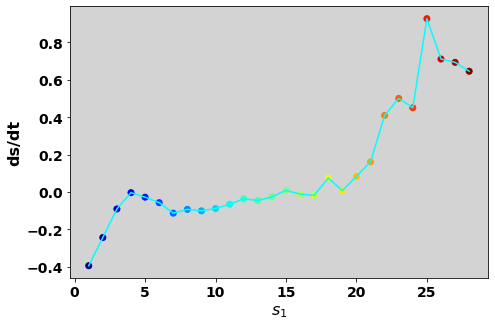

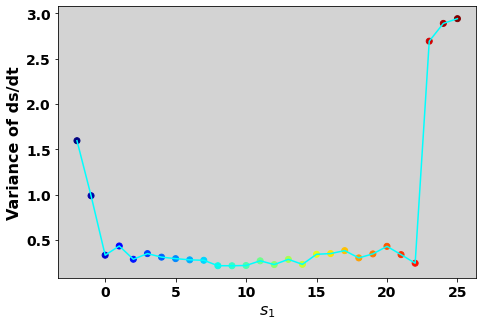

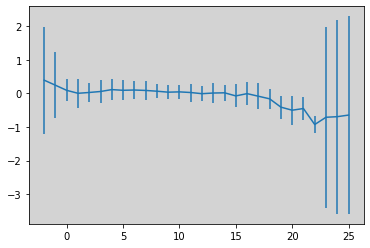

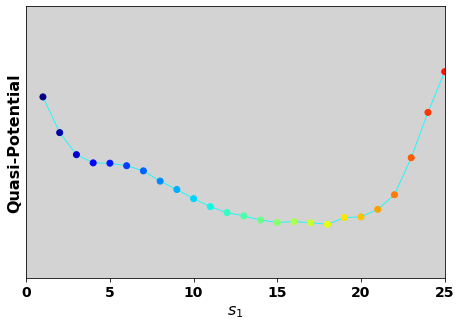

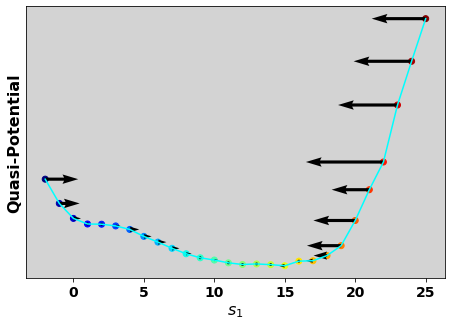

In [15]:
rc_flux_v1=np.zeros((len(extend_path1),))
rc_flux_D1=np.zeros((len(extend_path1),))
for j in range(len(extend_path1)):
#     plt.hist(np.array(rc_grad[j]))
#     plt.show()
    print(j,len(rc_grad1[j]))
    rc_flux_v1[j]=np.mean(np.array(rc_grad1[j]))
    rc_flux_D1[j]=np.var(np.array(rc_grad1[j]))

rc_flux_v1[:branch_start]=rc_flux_v[:branch_start]
rc_flux_v1[branch_end-1:]=rc_flux_v[branch_end-1:]

rc_flux_D1[:branch_start]=rc_flux_D[:branch_start]
rc_flux_D1[branch_end-1:]=rc_flux_D[branch_end-1:]
print(rc_flux_v1)  

plt.figure(figsize=(7.5,5))

dot_color=np.arange(extend_path1.shape[0]-2)
cm=plt.cm.get_cmap('jet')
plt.plot(np.arange(1,len(rc_flux_v1[1:-1])+1),-rc_flux_v1[1:-1],color='cyan')

plt.scatter(np.arange(1,len(rc_flux_v1[1:-1])+1),-rc_flux_v1[1:-1],c=dot_color,cmap=cm)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'1ng_rc1_dSdt.png',dpi=300)
plt.show()

plt.figure(figsize=(7.5,5))
plt.plot(np.arange(-extend_range+1,nrc+extend_range-1),rc_flux_D1[1:-1],color='cyan')

plt.scatter(np.arange(-extend_range+1,nrc+extend_range-1),rc_flux_D1[1:-1],c=dot_color,cmap=cm)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Variance of ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'1ng_rc1_dSdt_var.png',dpi=300)
plt.show()
plt.errorbar(np.arange(-extend_range+1,nrc+extend_range-1),rc_flux_v1[1:-1],yerr=rc_flux_D1[1:-1])
plt.show()

quasi_V1=np.zeros((rc_flux_v1.shape[0]-2,))
for k in range(len(extend_path1)-2):
    quasi_V1[k]=np.sum(-rc_flux_v1[1:k+1])
plt.figure(figsize=(7.5,5))
plt.plot(np.arange(1,quasi_V1.shape[0]+1),quasi_V1,linewidth=0.8,color='cyan',zorder=1)

plt.scatter(np.arange(1,quasi_V1.shape[0]+1),quasi_V1,c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.axis([0,25,-2,1])
# plt.savefig(result_path+'1ng_rc1_potential.png',dpi=300)
# plt.axis([0,45,-4,-3])
plt.show()

plt.figure(figsize=(7.5,5))

plt.plot(np.arange(-extend_range+1,nrc+extend_range-1),quasi_V1,color='cyan')
plt.scatter(np.arange(-extend_range+1,nrc+extend_range-1),quasi_V1,c=dot_color,cmap=cm)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.quiver(np.arange(-extend_range+1,nrc+extend_range-1),quasi_V1,rc_flux_v1[1:-1],np.zeros_like(quasi_V1),scale=5)
plt.savefig(result_path+'rc1_potential_vf.png',dpi=300)

plt.show()

np.save(result_path+'1ng_rc1_var.npy',rc_flux_D1[1:-1])
np.save(result_path+'1ng_iU1.npy',quasi_V1)

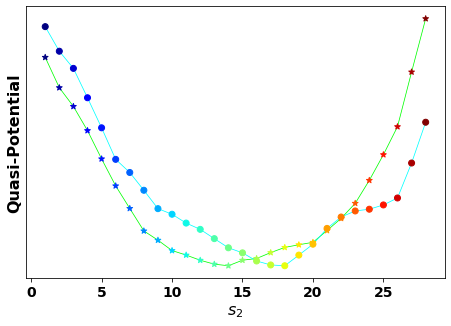

In [16]:
plt.figure(figsize=(7.5,5))
plt.rcParams['axes.facecolor'] = 'white' 
plt.plot(np.arange(1,quasi_V0.shape[0]+1),quasi_V0-np.amin(quasi_V0),linewidth=0.75,color='lime',zorder=1)

plt.scatter(np.arange(1,quasi_V0.shape[0]+1),quasi_V0-np.amin(quasi_V0),marker='*',c=dot_color,cmap=cm,zorder=2)
plt.plot(np.arange(1,quasi_V0.shape[0]+1),iU0-np.amin(iU0),linewidth=0.75,color='cyan',zorder=1)

plt.scatter(np.arange(1,quasi_V0.shape[0]+1),iU0-np.amin(iU0),c=dot_color,cmap=cm,zorder=2)

plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc0_potential_compare.png',dpi=300)
plt.show()


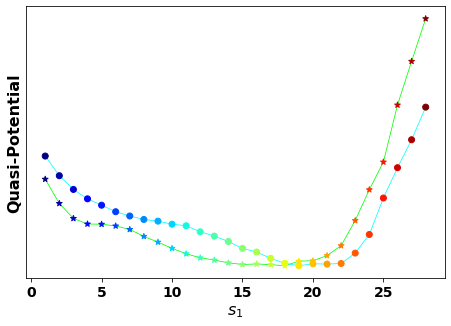

In [17]:
plt.figure(figsize=(7.5,5))

plt.plot(np.arange(1,quasi_V1.shape[0]+1),quasi_V1-np.amin(quasi_V1),linewidth=0.75,color='lime',zorder=1)

plt.scatter(np.arange(1,quasi_V1.shape[0]+1),quasi_V1-np.amin(quasi_V1),marker='*',c=dot_color,cmap=cm,zorder=2)
plt.plot(np.arange(1,quasi_V1.shape[0]+1),iU1-np.amin(iU1),linewidth=0.75,color='cyan',zorder=1)

plt.scatter(np.arange(1,quasi_V1.shape[0]+1),iU1-np.amin(iU1),c=dot_color,cmap=cm,zorder=2)

plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc1_potential_compare.png',dpi=300)
plt.show()